In [1]:
import os
import csv
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import v2 as T
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, confusion_matrix)
import seaborn as sns

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Sử dụng thiết bị: {device}")

Sử dụng thiết bị: cuda


In [3]:
class DynamicGraphAttention(nn.Module):
    def __init__(self, in_channels, num_nodes=32, heads=8, dropout=0.1):  # Tăng num_nodes/heads mặc định
        super().__init__()
        self.num_nodes = num_nodes
        self.heads = heads
        self.head_dim = in_channels // heads
        self.dropout = nn.Dropout(dropout)

        self.query = nn.Linear(in_channels, in_channels)
        self.key = nn.Linear(in_channels, in_channels)
        self.value = nn.Linear(in_channels, in_channels)
        self.out = nn.Linear(in_channels, in_channels)
        self.scale = nn.Parameter(torch.tensor(self.head_dim**-0.5))

        # Positional encoding (simple learnable)
        self.pos_enc = nn.Parameter(torch.randn(1, num_nodes, in_channels))

    def forward(self, x):
        B, C, H, W = x.size()
        x_flat = x.flatten(2).transpose(1, 2)  # (B, H*W, C)
        
        num_pixels = H * W
        N = min(self.num_nodes, num_pixels)
        
        # Importance sampling: Chọn top-k pixels dựa trên L2 norm (thay vì random/linspace)
        norms = torch.norm(x_flat, dim=-1)  # (B, H*W)
        _, indices = torch.topk(norms, N, dim=-1)  # Top-k indices
        indices = indices.sort(dim=-1).indices  # Sort để ổn định
        x_nodes = torch.gather(x_flat, 1, indices.unsqueeze(-1).expand(-1, -1, C))  # (B, N, C)
        
        # Thêm positional encoding
        x_nodes = x_nodes + self.pos_enc.expand(B, -1, -1)
        
        q = self.query(x_nodes).view(B, N, self.heads, self.head_dim).transpose(1, 2)
        k = self.key(x_nodes).view(B, N, self.heads, self.head_dim).transpose(1, 2)
        v = self.value(x_nodes).view(B, N, self.heads, self.head_dim).transpose(1, 2)
        
        attn_weights = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        attn_weights = F.softmax(attn_weights, dim=-1)
        attn_weights = self.dropout(attn_weights)  # Thêm dropout
        attn_output = torch.matmul(attn_weights, v)
        attn_output = attn_output.transpose(1, 2).contiguous().view(B, N, C)
        
        out_nodes = self.out(attn_output)
        
        out_flat = torch.zeros_like(x_flat)
        out_flat.scatter_(1, indices.unsqueeze(-1).expand(-1, -1, C), out_nodes)
        out = out_flat.transpose(1, 2).view(B, C, H, W)
        
        return x + out  # Residual connection

class TemporalAttentionAggregator(nn.Module):
    def __init__(self, in_channels, num_heads=4):
        super().__init__()
        self.attention_net = nn.MultiheadAttention(embed_dim=in_channels, num_heads=num_heads)  # Thay MLP bằng MultiheadAttention
        self.norm = nn.LayerNorm(in_channels)

    def forward(self, x):
        if len(x.shape) == 4:  # (B, C, H, W) -> Giả sử single frame, flatten spatial
            B, C, H, W = x.size()
            x_flat = x.flatten(2).transpose(1, 2)  # (B, H*W, C)
        elif len(x.shape) == 5:  # (B, T, C, H, W) -> Flatten temporal-spatial
            B, T, C, H, W = x.size()
            x_flat = x.flatten(3).transpose(2, 3).reshape(B, T * H * W, C)  # (B, T*H*W, C)
        else:
            raise ValueError("Input must be 4D or 5D tensor")
        
        # Temporal-spatial attention
        x_flat = self.norm(x_flat)
        attn_output, _ = self.attention_net(x_flat, x_flat, x_flat)  # Self-attention
        
        # Aggregate
        aggregated_vector = torch.mean(attn_output, dim=1)  # Mean pooling thay sum để ổn định
        return aggregated_vector

class InvertedResidual(nn.Module):
    def __init__(self, in_channels, out_channels, stride, expansion=6):  # Tăng expansion mặc định
        super().__init__()
        hidden_dim = in_channels * expansion
        self.use_residual = in_channels == out_channels and stride == 1
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, hidden_dim, 1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.SiLU(inplace=True),  # Thay ReLU6 bằng SiLU (Swish)
            nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.SiLU(inplace=True),
            nn.Conv2d(hidden_dim, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
        )
        
        # Thêm SE block
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(out_channels, out_channels // 16, 1),
            nn.SiLU(),
            nn.Conv2d(out_channels // 16, out_channels, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.conv(x)
        out = out * self.se(out)  # Áp dụng SE
        return x + out if self.use_residual else out

In [4]:
class PestLarvaNet_Small(nn.Module):
    def __init__(self, num_classes, input_channels=1):
        super().__init__()
        self.config = [[1, 24, 2, 1], [4, 32, 2, 2], [4, 56, 3, 2], [6, 96, 2, 2]]
        self.stem = nn.Sequential(
            nn.Conv2d(input_channels, 24, 3, 2, 1, bias=False),
            nn.BatchNorm2d(24), nn.SiLU(inplace=True))
        
        layers = []
        in_channels = 24
        for t, c, n, s in self.config:
            for i in range(n):
                stride = s if i == 0 else 1
                layers.append(InvertedResidual(in_channels, c, stride, expansion=t))
                in_channels = c
            if c == 32:
                layers.append(DynamicGraphAttention(in_channels, num_nodes=24, heads=4))
        self.body = nn.Sequential(*layers)

        self.head_conv = nn.Conv2d(96, 256, 1, bias=False)
        self.aggregator = TemporalAttentionAggregator(256, num_heads=8)
        self.classifier = nn.Sequential(
            nn.Linear(256, 128), nn.SiLU(inplace=True), nn.Dropout(0.3),
            nn.Linear(128, num_classes))
    
    def forward(self, x):
        x = self.stem(x); x = self.body(x); x = self.head_conv(x)
        x = self.aggregator(x); x = self.classifier(x); return x

In [5]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total, trainable

In [6]:
class InsectSpectrogramDataset(Dataset):
    """Dataset tùy chỉnh để đọc các file spectrogram .pt"""
    def __init__(self, metadata_file, data_dir, transform=None):
        self.metadata = pd.read_csv(metadata_file)
        self.data_dir = data_dir
        self.transform = transform
        self.file_column = 'file_name'
        self.label_column = 'label'
        
        self.class_names = sorted(self.metadata[self.label_column].unique())
        self.class_to_id = {name: i for i, name in enumerate(self.class_names)}
        self.id_to_class = {i: name for name, i in self.class_to_id.items()}

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        file_name = self.metadata.iloc[idx][self.file_column]
        file_path = os.path.join(self.data_dir, file_name)
        label_name = self.metadata.iloc[idx][self.label_column]
        label = self.class_to_id[label_name]
        
        try:
            spectrogram = torch.load(file_path)
            if spectrogram.dim() == 2:
                spectrogram = spectrogram.unsqueeze(0)
            if self.transform:
                spectrogram = self.transform(spectrogram)
            return spectrogram, label
        except Exception as e:
            print(f"Lỗi khi tải file {file_path}: {e}")
            return torch.zeros(1, 128, 259), -1 # Trả về mẫu lỗi

In [7]:
METADATA_PATH = r'F:/Working Sync/LAB projects/InsectSELD/Dataset/metadata_Mel.csv' 
DATA_DIR = r'F:/Working Sync/LAB projects/InsectSELD/Dataset/MelSpectrograms'

In [8]:
class TimeShift(torch.nn.Module):
    """ Dịch chuyển spectrogram theo trục thời gian một cách ngẫu nhiên. """
    def __init__(self, p=0.5, max_shift_percent=0.4):
        super().__init__()
        self.p = p
        self.max_shift_percent = max_shift_percent

    def forward(self, spec):
        if torch.rand(1) < self.p:
            time_steps = spec.shape[-1]
            # Chọn một lượng dịch chuyển ngẫu nhiên
            shift_amount = int(torch.rand(1) * self.max_shift_percent * time_steps)
            # Dịch ngẫu nhiên sang trái hoặc phải
            if torch.rand(1) < 0.5:
                shift_amount = -shift_amount
            return torch.roll(spec, shifts=shift_amount, dims=-1)
        return spec

class SpecNoise(torch.nn.Module):
    """ Thêm nhiễu Gaussian trực tiếp vào spectrogram. """
    def __init__(self, p=0.5, noise_level=0.05):
        super().__init__()
        self.p = p
        self.noise_level = noise_level

    def forward(self, spec):
        if torch.rand(1) < self.p:
            noise = torch.randn_like(spec) * self.noise_level
            return spec + noise
        return spec

In [9]:
train_transform = T.Compose([
    # Kỹ thuật 1: SpecAugment (Time & Frequency Masking)
    torchaudio.transforms.TimeMasking(time_mask_param=80),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=25),
    
    # Kỹ thuật 2: Time Shifting
    TimeShift(p=0.5, max_shift_percent=0.4),
    
    # Kỹ thuật 3: Spectrogram Noise
    SpecNoise(p=0.3, noise_level=0.03),
])

# Tập validation không sử dụng augmentation
val_transform = None

print("Đã định nghĩa xong pipeline Augmentation cho Spectrogram.")

Đã định nghĩa xong pipeline Augmentation cho Spectrogram.


In [10]:
def mixup_data(x, y, alpha=0.4, use_cuda=True):
    """
    Trộn dữ liệu trong một batch.
    Trả về input đã trộn, và hai bộ nhãn gốc cùng với hệ số trộn lambda.
    """
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """
    Hàm tính loss đặc biệt cho Mixup.
    """
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [11]:
if not os.path.exists(METADATA_PATH) or not os.path.isdir(DATA_DIR):
    print("!!! LỖI: Vui lòng kiểm tra lại đường dẫn METADATA_PATH và DATA_DIR.")
else:
    full_dataset = InsectSpectrogramDataset(METADATA_PATH, DATA_DIR)
    num_classes = len(full_dataset.class_names)
    print(f"Tải dữ liệu thành công: {len(full_dataset)} mẫu, {num_classes} lớp.")

    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    generator = torch.Generator().manual_seed(42)
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size], generator)

    train_dataset.dataset.transform = train_transform
    val_dataset.dataset.transform = val_transform

    BATCH_SIZE = 32
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

Tải dữ liệu thành công: 165982 mẫu, 12 lớp.


In [12]:
EPOCHS = 100
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-4

CHECKPOINT_DIR = r'F:/Working Sync/LAB projects/InsectSELD/Dataset/checkpoints_small'
LOG_CSV_PATH = 'F:/Working Sync/LAB projects/InsectSELD/Dataset/training_log_small.csv'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

In [13]:
model = PestLarvaNet_Small(num_classes=num_classes).to(device)
total_params, _ = count_parameters(model)
print(f"Khởi tạo mô hình PestLarvaNet-GMA với {total_params/1e6:.2f}M tham số.")

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

Khởi tạo mô hình PestLarvaNet-GMA với 0.59M tham số.


In [15]:
log_header = [
    'epoch', 'train_loss', 'val_loss', 'learning_rate',
    'accuracy', 'precision', 'recall', 'f1'
]
# --- KẾT THÚC THAY ĐỔI ---

with open(LOG_CSV_PATH, 'w', newline='', encoding='utf-8') as f:
    csv.writer(f).writerow(log_header)

print(f"\nBắt đầu huấn luyện... Checkpoints sẽ được lưu tại '{CHECKPOINT_DIR}' và log tại '{LOG_CSV_PATH}'")

# --- Vòng lặp huấn luyện chính ---
best_val_f1 = 0.0


Bắt đầu huấn luyện... Checkpoints sẽ được lưu tại 'F:/Working Sync/LAB projects/InsectSELD/Dataset/checkpoints_small' và log tại 'F:/Working Sync/LAB projects/InsectSELD/Dataset/training_log_small.csv'


In [16]:
for epoch in range(EPOCHS):
    # ---- Train ----
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Training]")
    
    for inputs, labels in progress_bar:
        if -1 in labels:
            continue  
        inputs, labels = inputs.to(device), labels.to(device)

        # Mixup 50%
        optimizer.zero_grad()
        if torch.rand(1).item() < 0.5:
            inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, alpha=0.4)
            outputs = model(inputs)
            loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
        else:
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        progress_bar.set_postfix(loss=f"{loss.item():.4f}")

    # ---- Validate ----
    model.eval()
    val_loss = 0.0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Validation]"):
            if -1 in labels:
                continue
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs.data, 1)
            val_preds.extend(predicted.cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    epoch_train_loss = running_loss / len(train_dataset)
    epoch_val_loss   = val_loss / len(val_dataset)

    # ==== METRICS (micro-average “bình thường”) ====
    accuracy  = accuracy_score(val_labels, val_preds)
    precision = precision_score(val_labels, val_preds, average='micro', zero_division=0)
    recall    = recall_score(val_labels, val_preds, average='micro', zero_division=0)
    f1        = f1_score(val_labels, val_preds, average='micro', zero_division=0)

    current_lr = scheduler.get_last_lr()[0]
    scheduler.step()

    # ---- Print summary ----
    print(f"\n--- Epoch {epoch+1}/{EPOCHS} Summary ---")
    print(f"  Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f}")
    print(f"  Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}")
    print(f"  Learning Rate: {current_lr:.6f}")

    # ---- Log CSV ----
    log_data = [epoch + 1, epoch_train_loss, epoch_val_loss, current_lr,
                accuracy, precision, recall, f1]
    with open(LOG_CSV_PATH, 'a', newline='', encoding='utf-8') as f:
        csv.writer(f).writerow(log_data)

    # ---- Save checkpoint ----
    checkpoint_path = os.path.join(CHECKPOINT_DIR, f'checkpoint_epoch_{epoch+1}.pth')
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, checkpoint_path)

    # ---- Best model theo F1 (micro) ----
    if f1 > best_val_f1:
        best_val_f1 = f1
        best_model_path = os.path.join(CHECKPOINT_DIR, 'best_model.pth')
        torch.save(model.state_dict(), best_model_path)
        print(f"  => 🎉 New best model saved to '{best_model_path}' (F1: {best_val_f1:.4f})\n")

print("\n✅ Hoàn tất huấn luyện!")

Epoch 1/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 1/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 1/100 Summary ---
  Train Loss: 1.2711 | Val Loss: 1.1898
  Accuracy: 0.6208 | Precision: 0.6208 | Recall: 0.6208 | F1: 0.6208
  Learning Rate: 0.001000
  => 🎉 New best model saved to 'F:/Working Sync/LAB projects/InsectSELD/Dataset/checkpoints_small\best_model.pth' (F1: 0.6208)



Epoch 2/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 2/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 2/100 Summary ---
  Train Loss: 1.0462 | Val Loss: 0.7073
  Accuracy: 0.7588 | Precision: 0.7588 | Recall: 0.7588 | F1: 0.7588
  Learning Rate: 0.001000
  => 🎉 New best model saved to 'F:/Working Sync/LAB projects/InsectSELD/Dataset/checkpoints_small\best_model.pth' (F1: 0.7588)



Epoch 3/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 3/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 3/100 Summary ---
  Train Loss: 0.9409 | Val Loss: 0.7907
  Accuracy: 0.7266 | Precision: 0.7266 | Recall: 0.7266 | F1: 0.7266
  Learning Rate: 0.000999


Epoch 4/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 4/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 4/100 Summary ---
  Train Loss: 0.8769 | Val Loss: 1.0227
  Accuracy: 0.6690 | Precision: 0.6690 | Recall: 0.6690 | F1: 0.6690
  Learning Rate: 0.000998


Epoch 5/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 5/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 5/100 Summary ---
  Train Loss: 0.8385 | Val Loss: 0.8022
  Accuracy: 0.7271 | Precision: 0.7271 | Recall: 0.7271 | F1: 0.7271
  Learning Rate: 0.000996


Epoch 6/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 6/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 6/100 Summary ---
  Train Loss: 0.7807 | Val Loss: 0.8685
  Accuracy: 0.7054 | Precision: 0.7054 | Recall: 0.7054 | F1: 0.7054
  Learning Rate: 0.000994


Epoch 7/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 7/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 7/100 Summary ---
  Train Loss: 0.7387 | Val Loss: 1.6399
  Accuracy: 0.5169 | Precision: 0.5169 | Recall: 0.5169 | F1: 0.5169
  Learning Rate: 0.000991


Epoch 8/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 8/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 8/100 Summary ---
  Train Loss: 0.6960 | Val Loss: 0.4904
  Accuracy: 0.8309 | Precision: 0.8309 | Recall: 0.8309 | F1: 0.8309
  Learning Rate: 0.000988
  => 🎉 New best model saved to 'F:/Working Sync/LAB projects/InsectSELD/Dataset/checkpoints_small\best_model.pth' (F1: 0.8309)



Epoch 9/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 9/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 9/100 Summary ---
  Train Loss: 0.6663 | Val Loss: 0.4924
  Accuracy: 0.8307 | Precision: 0.8307 | Recall: 0.8307 | F1: 0.8307
  Learning Rate: 0.000984


Epoch 10/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 10/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 10/100 Summary ---
  Train Loss: 0.6424 | Val Loss: 0.6137
  Accuracy: 0.7966 | Precision: 0.7966 | Recall: 0.7966 | F1: 0.7966
  Learning Rate: 0.000980


Epoch 11/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 11/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 11/100 Summary ---
  Train Loss: 0.6029 | Val Loss: 0.4998
  Accuracy: 0.8328 | Precision: 0.8328 | Recall: 0.8328 | F1: 0.8328
  Learning Rate: 0.000976
  => 🎉 New best model saved to 'F:/Working Sync/LAB projects/InsectSELD/Dataset/checkpoints_small\best_model.pth' (F1: 0.8328)



Epoch 12/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 12/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 12/100 Summary ---
  Train Loss: 0.5830 | Val Loss: 0.7576
  Accuracy: 0.7672 | Precision: 0.7672 | Recall: 0.7672 | F1: 0.7672
  Learning Rate: 0.000970


Epoch 13/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 13/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 13/100 Summary ---
  Train Loss: 0.5686 | Val Loss: 0.3054
  Accuracy: 0.8946 | Precision: 0.8946 | Recall: 0.8946 | F1: 0.8946
  Learning Rate: 0.000965
  => 🎉 New best model saved to 'F:/Working Sync/LAB projects/InsectSELD/Dataset/checkpoints_small\best_model.pth' (F1: 0.8946)



Epoch 14/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 14/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 14/100 Summary ---
  Train Loss: 0.5621 | Val Loss: 0.5643
  Accuracy: 0.8209 | Precision: 0.8209 | Recall: 0.8209 | F1: 0.8209
  Learning Rate: 0.000959


Epoch 15/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 15/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 15/100 Summary ---
  Train Loss: 0.5468 | Val Loss: 0.4421
  Accuracy: 0.8532 | Precision: 0.8532 | Recall: 0.8532 | F1: 0.8532
  Learning Rate: 0.000952


Epoch 16/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 16/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 16/100 Summary ---
  Train Loss: 0.5350 | Val Loss: 0.2747
  Accuracy: 0.9060 | Precision: 0.9060 | Recall: 0.9060 | F1: 0.9060
  Learning Rate: 0.000946
  => 🎉 New best model saved to 'F:/Working Sync/LAB projects/InsectSELD/Dataset/checkpoints_small\best_model.pth' (F1: 0.9060)



Epoch 17/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 17/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 17/100 Summary ---
  Train Loss: 0.5286 | Val Loss: 0.5185
  Accuracy: 0.8278 | Precision: 0.8278 | Recall: 0.8278 | F1: 0.8278
  Learning Rate: 0.000938


Epoch 18/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 18/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 18/100 Summary ---
  Train Loss: 0.5170 | Val Loss: 1.1604
  Accuracy: 0.6623 | Precision: 0.6623 | Recall: 0.6623 | F1: 0.6623
  Learning Rate: 0.000930


Epoch 19/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 19/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 19/100 Summary ---
  Train Loss: 0.5055 | Val Loss: 0.5232
  Accuracy: 0.8296 | Precision: 0.8296 | Recall: 0.8296 | F1: 0.8296
  Learning Rate: 0.000922


Epoch 20/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 20/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 20/100 Summary ---
  Train Loss: 0.4979 | Val Loss: 0.2825
  Accuracy: 0.9033 | Precision: 0.9033 | Recall: 0.9033 | F1: 0.9033
  Learning Rate: 0.000914


Epoch 21/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 21/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 21/100 Summary ---
  Train Loss: 0.4876 | Val Loss: 0.3790
  Accuracy: 0.8766 | Precision: 0.8766 | Recall: 0.8766 | F1: 0.8766
  Learning Rate: 0.000905


Epoch 22/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 22/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 22/100 Summary ---
  Train Loss: 0.4798 | Val Loss: 0.3241
  Accuracy: 0.8936 | Precision: 0.8936 | Recall: 0.8936 | F1: 0.8936
  Learning Rate: 0.000895


Epoch 23/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 23/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 23/100 Summary ---
  Train Loss: 0.4697 | Val Loss: 0.8296
  Accuracy: 0.7741 | Precision: 0.7741 | Recall: 0.7741 | F1: 0.7741
  Learning Rate: 0.000885


Epoch 24/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 24/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 24/100 Summary ---
  Train Loss: 0.4631 | Val Loss: 0.3197
  Accuracy: 0.8957 | Precision: 0.8957 | Recall: 0.8957 | F1: 0.8957
  Learning Rate: 0.000875


Epoch 25/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 25/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 25/100 Summary ---
  Train Loss: 0.4698 | Val Loss: 0.2747
  Accuracy: 0.9096 | Precision: 0.9096 | Recall: 0.9096 | F1: 0.9096
  Learning Rate: 0.000864
  => 🎉 New best model saved to 'F:/Working Sync/LAB projects/InsectSELD/Dataset/checkpoints_small\best_model.pth' (F1: 0.9096)



Epoch 26/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 26/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 26/100 Summary ---
  Train Loss: 0.4475 | Val Loss: 0.4551
  Accuracy: 0.8609 | Precision: 0.8609 | Recall: 0.8609 | F1: 0.8609
  Learning Rate: 0.000854


Epoch 27/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 27/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 27/100 Summary ---
  Train Loss: 0.4340 | Val Loss: 0.7660
  Accuracy: 0.8074 | Precision: 0.8074 | Recall: 0.8074 | F1: 0.8074
  Learning Rate: 0.000842


Epoch 28/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 28/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 28/100 Summary ---
  Train Loss: 0.4374 | Val Loss: 0.3691
  Accuracy: 0.8881 | Precision: 0.8881 | Recall: 0.8881 | F1: 0.8881
  Learning Rate: 0.000831


Epoch 29/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 29/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 29/100 Summary ---
  Train Loss: 0.4300 | Val Loss: 0.2803
  Accuracy: 0.9113 | Precision: 0.9113 | Recall: 0.9113 | F1: 0.9113
  Learning Rate: 0.000819
  => 🎉 New best model saved to 'F:/Working Sync/LAB projects/InsectSELD/Dataset/checkpoints_small\best_model.pth' (F1: 0.9113)



Epoch 30/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 30/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 30/100 Summary ---
  Train Loss: 0.4312 | Val Loss: 0.2732
  Accuracy: 0.9137 | Precision: 0.9137 | Recall: 0.9137 | F1: 0.9137
  Learning Rate: 0.000806
  => 🎉 New best model saved to 'F:/Working Sync/LAB projects/InsectSELD/Dataset/checkpoints_small\best_model.pth' (F1: 0.9137)



Epoch 31/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 31/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 31/100 Summary ---
  Train Loss: 0.4226 | Val Loss: 0.5104
  Accuracy: 0.8546 | Precision: 0.8546 | Recall: 0.8546 | F1: 0.8546
  Learning Rate: 0.000794


Epoch 32/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 32/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 32/100 Summary ---
  Train Loss: 0.4194 | Val Loss: 0.3019
  Accuracy: 0.9084 | Precision: 0.9084 | Recall: 0.9084 | F1: 0.9084
  Learning Rate: 0.000781


Epoch 33/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 33/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 33/100 Summary ---
  Train Loss: 0.3998 | Val Loss: 0.2676
  Accuracy: 0.9160 | Precision: 0.9160 | Recall: 0.9160 | F1: 0.9160
  Learning Rate: 0.000768
  => 🎉 New best model saved to 'F:/Working Sync/LAB projects/InsectSELD/Dataset/checkpoints_small\best_model.pth' (F1: 0.9160)



Epoch 34/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 34/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 34/100 Summary ---
  Train Loss: 0.3975 | Val Loss: 0.3088
  Accuracy: 0.9079 | Precision: 0.9079 | Recall: 0.9079 | F1: 0.9079
  Learning Rate: 0.000755


Epoch 35/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 35/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 35/100 Summary ---
  Train Loss: 0.4057 | Val Loss: 0.2998
  Accuracy: 0.9116 | Precision: 0.9116 | Recall: 0.9116 | F1: 0.9116
  Learning Rate: 0.000741


Epoch 36/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 36/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 36/100 Summary ---
  Train Loss: 0.3990 | Val Loss: 0.3037
  Accuracy: 0.9100 | Precision: 0.9100 | Recall: 0.9100 | F1: 0.9100
  Learning Rate: 0.000727


Epoch 37/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 37/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 37/100 Summary ---
  Train Loss: 0.3965 | Val Loss: 0.3985
  Accuracy: 0.8887 | Precision: 0.8887 | Recall: 0.8887 | F1: 0.8887
  Learning Rate: 0.000713


Epoch 38/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 38/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 38/100 Summary ---
  Train Loss: 0.3816 | Val Loss: 0.4187
  Accuracy: 0.8936 | Precision: 0.8936 | Recall: 0.8936 | F1: 0.8936
  Learning Rate: 0.000699


Epoch 39/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 39/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 39/100 Summary ---
  Train Loss: 0.3722 | Val Loss: 0.3157
  Accuracy: 0.9113 | Precision: 0.9113 | Recall: 0.9113 | F1: 0.9113
  Learning Rate: 0.000684


Epoch 40/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 40/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 40/100 Summary ---
  Train Loss: 0.3714 | Val Loss: 0.6454
  Accuracy: 0.8510 | Precision: 0.8510 | Recall: 0.8510 | F1: 0.8510
  Learning Rate: 0.000669


Epoch 41/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 41/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 41/100 Summary ---
  Train Loss: 0.3638 | Val Loss: 0.4477
  Accuracy: 0.8801 | Precision: 0.8801 | Recall: 0.8801 | F1: 0.8801
  Learning Rate: 0.000655


Epoch 42/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 42/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 42/100 Summary ---
  Train Loss: 0.3799 | Val Loss: 0.3060
  Accuracy: 0.9158 | Precision: 0.9158 | Recall: 0.9158 | F1: 0.9158
  Learning Rate: 0.000639


Epoch 43/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 43/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 43/100 Summary ---
  Train Loss: 0.3640 | Val Loss: 0.3167
  Accuracy: 0.9128 | Precision: 0.9128 | Recall: 0.9128 | F1: 0.9128
  Learning Rate: 0.000624


Epoch 44/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 44/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 44/100 Summary ---
  Train Loss: 0.3726 | Val Loss: 0.3422
  Accuracy: 0.9081 | Precision: 0.9081 | Recall: 0.9081 | F1: 0.9081
  Learning Rate: 0.000609


Epoch 45/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 45/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 45/100 Summary ---
  Train Loss: 0.3621 | Val Loss: 0.3170
  Accuracy: 0.9074 | Precision: 0.9074 | Recall: 0.9074 | F1: 0.9074
  Learning Rate: 0.000594


Epoch 46/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 46/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 46/100 Summary ---
  Train Loss: 0.3568 | Val Loss: 0.4332
  Accuracy: 0.8778 | Precision: 0.8778 | Recall: 0.8778 | F1: 0.8778
  Learning Rate: 0.000578


Epoch 47/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 47/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 47/100 Summary ---
  Train Loss: 0.3676 | Val Loss: 0.3229
  Accuracy: 0.9177 | Precision: 0.9177 | Recall: 0.9177 | F1: 0.9177
  Learning Rate: 0.000563
  => 🎉 New best model saved to 'F:/Working Sync/LAB projects/InsectSELD/Dataset/checkpoints_small\best_model.pth' (F1: 0.9177)



Epoch 48/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 48/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 48/100 Summary ---
  Train Loss: 0.3583 | Val Loss: 0.3441
  Accuracy: 0.9134 | Precision: 0.9134 | Recall: 0.9134 | F1: 0.9134
  Learning Rate: 0.000547


Epoch 49/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 49/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 49/100 Summary ---
  Train Loss: 0.3471 | Val Loss: 0.4674
  Accuracy: 0.8626 | Precision: 0.8626 | Recall: 0.8626 | F1: 0.8626
  Learning Rate: 0.000531


Epoch 50/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 50/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 50/100 Summary ---
  Train Loss: 0.3505 | Val Loss: 0.3355
  Accuracy: 0.9160 | Precision: 0.9160 | Recall: 0.9160 | F1: 0.9160
  Learning Rate: 0.000516


Epoch 51/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 51/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 51/100 Summary ---
  Train Loss: 0.3511 | Val Loss: 0.4091
  Accuracy: 0.9004 | Precision: 0.9004 | Recall: 0.9004 | F1: 0.9004
  Learning Rate: 0.000500


Epoch 52/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 52/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 52/100 Summary ---
  Train Loss: 0.3336 | Val Loss: 0.3451
  Accuracy: 0.9173 | Precision: 0.9173 | Recall: 0.9173 | F1: 0.9173
  Learning Rate: 0.000484


Epoch 53/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 53/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 53/100 Summary ---
  Train Loss: 0.3505 | Val Loss: 0.3329
  Accuracy: 0.9107 | Precision: 0.9107 | Recall: 0.9107 | F1: 0.9107
  Learning Rate: 0.000469


Epoch 54/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 54/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 54/100 Summary ---
  Train Loss: 0.3457 | Val Loss: 0.3325
  Accuracy: 0.9132 | Precision: 0.9132 | Recall: 0.9132 | F1: 0.9132
  Learning Rate: 0.000453


Epoch 55/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 55/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 55/100 Summary ---
  Train Loss: 0.3444 | Val Loss: 0.3401
  Accuracy: 0.9162 | Precision: 0.9162 | Recall: 0.9162 | F1: 0.9162
  Learning Rate: 0.000437


Epoch 56/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 56/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 56/100 Summary ---
  Train Loss: 0.3311 | Val Loss: 0.3314
  Accuracy: 0.9195 | Precision: 0.9195 | Recall: 0.9195 | F1: 0.9195
  Learning Rate: 0.000422
  => 🎉 New best model saved to 'F:/Working Sync/LAB projects/InsectSELD/Dataset/checkpoints_small\best_model.pth' (F1: 0.9195)



Epoch 57/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 57/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 57/100 Summary ---
  Train Loss: 0.3367 | Val Loss: 0.3491
  Accuracy: 0.9197 | Precision: 0.9197 | Recall: 0.9197 | F1: 0.9197
  Learning Rate: 0.000406
  => 🎉 New best model saved to 'F:/Working Sync/LAB projects/InsectSELD/Dataset/checkpoints_small\best_model.pth' (F1: 0.9197)



Epoch 58/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 58/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 58/100 Summary ---
  Train Loss: 0.3299 | Val Loss: 0.3418
  Accuracy: 0.9152 | Precision: 0.9152 | Recall: 0.9152 | F1: 0.9152
  Learning Rate: 0.000391


Epoch 59/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 59/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 59/100 Summary ---
  Train Loss: 0.3315 | Val Loss: 0.3563
  Accuracy: 0.9199 | Precision: 0.9199 | Recall: 0.9199 | F1: 0.9199
  Learning Rate: 0.000376
  => 🎉 New best model saved to 'F:/Working Sync/LAB projects/InsectSELD/Dataset/checkpoints_small\best_model.pth' (F1: 0.9199)



Epoch 60/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 60/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 60/100 Summary ---
  Train Loss: 0.3309 | Val Loss: 0.3445
  Accuracy: 0.9188 | Precision: 0.9188 | Recall: 0.9188 | F1: 0.9188
  Learning Rate: 0.000361


Epoch 61/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 61/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 61/100 Summary ---
  Train Loss: 0.3304 | Val Loss: 0.3644
  Accuracy: 0.9156 | Precision: 0.9156 | Recall: 0.9156 | F1: 0.9156
  Learning Rate: 0.000345


Epoch 62/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 62/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 62/100 Summary ---
  Train Loss: 0.3091 | Val Loss: 0.3626
  Accuracy: 0.9183 | Precision: 0.9183 | Recall: 0.9183 | F1: 0.9183
  Learning Rate: 0.000331


Epoch 63/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 63/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 63/100 Summary ---
  Train Loss: 0.3250 | Val Loss: 0.3511
  Accuracy: 0.9141 | Precision: 0.9141 | Recall: 0.9141 | F1: 0.9141
  Learning Rate: 0.000316


Epoch 64/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 64/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 64/100 Summary ---
  Train Loss: 0.3173 | Val Loss: 0.3719
  Accuracy: 0.9164 | Precision: 0.9164 | Recall: 0.9164 | F1: 0.9164
  Learning Rate: 0.000301


Epoch 65/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 65/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 65/100 Summary ---
  Train Loss: 0.3229 | Val Loss: 0.3853
  Accuracy: 0.9188 | Precision: 0.9188 | Recall: 0.9188 | F1: 0.9188
  Learning Rate: 0.000287


Epoch 66/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 66/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 66/100 Summary ---
  Train Loss: 0.3146 | Val Loss: 0.3532
  Accuracy: 0.9230 | Precision: 0.9230 | Recall: 0.9230 | F1: 0.9230
  Learning Rate: 0.000273
  => 🎉 New best model saved to 'F:/Working Sync/LAB projects/InsectSELD/Dataset/checkpoints_small\best_model.pth' (F1: 0.9230)



Epoch 67/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 67/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 67/100 Summary ---
  Train Loss: 0.3173 | Val Loss: 0.3677
  Accuracy: 0.9197 | Precision: 0.9197 | Recall: 0.9197 | F1: 0.9197
  Learning Rate: 0.000259


Epoch 68/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 68/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 68/100 Summary ---
  Train Loss: 0.3185 | Val Loss: 0.3675
  Accuracy: 0.9163 | Precision: 0.9163 | Recall: 0.9163 | F1: 0.9163
  Learning Rate: 0.000245


Epoch 69/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 69/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 69/100 Summary ---
  Train Loss: 0.3066 | Val Loss: 0.3574
  Accuracy: 0.9212 | Precision: 0.9212 | Recall: 0.9212 | F1: 0.9212
  Learning Rate: 0.000232


Epoch 70/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 70/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 70/100 Summary ---
  Train Loss: 0.3071 | Val Loss: 0.3471
  Accuracy: 0.9204 | Precision: 0.9204 | Recall: 0.9204 | F1: 0.9204
  Learning Rate: 0.000219


Epoch 71/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 71/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 71/100 Summary ---
  Train Loss: 0.3053 | Val Loss: 0.3617
  Accuracy: 0.9225 | Precision: 0.9225 | Recall: 0.9225 | F1: 0.9225
  Learning Rate: 0.000206


Epoch 72/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 72/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 72/100 Summary ---
  Train Loss: 0.3098 | Val Loss: 0.3954
  Accuracy: 0.9197 | Precision: 0.9197 | Recall: 0.9197 | F1: 0.9197
  Learning Rate: 0.000194


Epoch 73/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 73/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 73/100 Summary ---
  Train Loss: 0.3132 | Val Loss: 0.3536
  Accuracy: 0.9226 | Precision: 0.9226 | Recall: 0.9226 | F1: 0.9226
  Learning Rate: 0.000181


Epoch 74/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 74/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 74/100 Summary ---
  Train Loss: 0.3006 | Val Loss: 0.3602
  Accuracy: 0.9220 | Precision: 0.9220 | Recall: 0.9220 | F1: 0.9220
  Learning Rate: 0.000169


Epoch 75/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 75/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 75/100 Summary ---
  Train Loss: 0.3073 | Val Loss: 0.3784
  Accuracy: 0.9220 | Precision: 0.9220 | Recall: 0.9220 | F1: 0.9220
  Learning Rate: 0.000158


Epoch 76/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 76/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 76/100 Summary ---
  Train Loss: 0.2978 | Val Loss: 0.4150
  Accuracy: 0.9183 | Precision: 0.9183 | Recall: 0.9183 | F1: 0.9183
  Learning Rate: 0.000146


Epoch 77/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 77/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 77/100 Summary ---
  Train Loss: 0.3085 | Val Loss: 0.3418
  Accuracy: 0.9205 | Precision: 0.9205 | Recall: 0.9205 | F1: 0.9205
  Learning Rate: 0.000136


Epoch 78/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 78/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 78/100 Summary ---
  Train Loss: 0.3077 | Val Loss: 0.3834
  Accuracy: 0.9222 | Precision: 0.9222 | Recall: 0.9222 | F1: 0.9222
  Learning Rate: 0.000125


Epoch 79/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 79/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 79/100 Summary ---
  Train Loss: 0.3129 | Val Loss: 0.3594
  Accuracy: 0.9216 | Precision: 0.9216 | Recall: 0.9216 | F1: 0.9216
  Learning Rate: 0.000115


Epoch 80/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 80/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 80/100 Summary ---
  Train Loss: 0.2961 | Val Loss: 0.3764
  Accuracy: 0.9173 | Precision: 0.9173 | Recall: 0.9173 | F1: 0.9173
  Learning Rate: 0.000105


Epoch 81/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 81/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 81/100 Summary ---
  Train Loss: 0.3066 | Val Loss: 0.3637
  Accuracy: 0.9232 | Precision: 0.9232 | Recall: 0.9232 | F1: 0.9232
  Learning Rate: 0.000095
  => 🎉 New best model saved to 'F:/Working Sync/LAB projects/InsectSELD/Dataset/checkpoints_small\best_model.pth' (F1: 0.9232)



Epoch 82/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 82/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 82/100 Summary ---
  Train Loss: 0.2898 | Val Loss: 0.3702
  Accuracy: 0.9229 | Precision: 0.9229 | Recall: 0.9229 | F1: 0.9229
  Learning Rate: 0.000086


Epoch 83/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 83/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 83/100 Summary ---
  Train Loss: 0.3054 | Val Loss: 0.4076
  Accuracy: 0.9149 | Precision: 0.9149 | Recall: 0.9149 | F1: 0.9149
  Learning Rate: 0.000078


Epoch 84/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 84/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 84/100 Summary ---
  Train Loss: 0.3059 | Val Loss: 0.3663
  Accuracy: 0.9232 | Precision: 0.9232 | Recall: 0.9232 | F1: 0.9232
  Learning Rate: 0.000070


Epoch 85/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 85/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 85/100 Summary ---
  Train Loss: 0.3022 | Val Loss: 0.3679
  Accuracy: 0.9213 | Precision: 0.9213 | Recall: 0.9213 | F1: 0.9213
  Learning Rate: 0.000062


Epoch 86/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 86/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 86/100 Summary ---
  Train Loss: 0.3039 | Val Loss: 0.3821
  Accuracy: 0.9213 | Precision: 0.9213 | Recall: 0.9213 | F1: 0.9213
  Learning Rate: 0.000054


Epoch 87/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 87/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 87/100 Summary ---
  Train Loss: 0.3049 | Val Loss: 0.3717
  Accuracy: 0.9237 | Precision: 0.9237 | Recall: 0.9237 | F1: 0.9237
  Learning Rate: 0.000048
  => 🎉 New best model saved to 'F:/Working Sync/LAB projects/InsectSELD/Dataset/checkpoints_small\best_model.pth' (F1: 0.9237)



Epoch 88/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 88/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 88/100 Summary ---
  Train Loss: 0.2911 | Val Loss: 0.3738
  Accuracy: 0.9245 | Precision: 0.9245 | Recall: 0.9245 | F1: 0.9245
  Learning Rate: 0.000041
  => 🎉 New best model saved to 'F:/Working Sync/LAB projects/InsectSELD/Dataset/checkpoints_small\best_model.pth' (F1: 0.9245)



Epoch 89/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 89/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 89/100 Summary ---
  Train Loss: 0.2885 | Val Loss: 0.3612
  Accuracy: 0.9246 | Precision: 0.9246 | Recall: 0.9246 | F1: 0.9246
  Learning Rate: 0.000035
  => 🎉 New best model saved to 'F:/Working Sync/LAB projects/InsectSELD/Dataset/checkpoints_small\best_model.pth' (F1: 0.9246)



Epoch 90/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 90/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 90/100 Summary ---
  Train Loss: 0.2967 | Val Loss: 0.3783
  Accuracy: 0.9235 | Precision: 0.9235 | Recall: 0.9235 | F1: 0.9235
  Learning Rate: 0.000030


Epoch 91/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 91/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 91/100 Summary ---
  Train Loss: 0.3081 | Val Loss: 0.3654
  Accuracy: 0.9233 | Precision: 0.9233 | Recall: 0.9233 | F1: 0.9233
  Learning Rate: 0.000024


Epoch 92/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 92/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 92/100 Summary ---
  Train Loss: 0.3056 | Val Loss: 0.3655
  Accuracy: 0.9246 | Precision: 0.9246 | Recall: 0.9246 | F1: 0.9246
  Learning Rate: 0.000020


Epoch 93/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 93/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 93/100 Summary ---
  Train Loss: 0.2980 | Val Loss: 0.3713
  Accuracy: 0.9257 | Precision: 0.9257 | Recall: 0.9257 | F1: 0.9257
  Learning Rate: 0.000016
  => 🎉 New best model saved to 'F:/Working Sync/LAB projects/InsectSELD/Dataset/checkpoints_small\best_model.pth' (F1: 0.9257)



Epoch 94/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 94/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 94/100 Summary ---
  Train Loss: 0.3046 | Val Loss: 0.3677
  Accuracy: 0.9225 | Precision: 0.9225 | Recall: 0.9225 | F1: 0.9225
  Learning Rate: 0.000012


Epoch 95/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 95/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 95/100 Summary ---
  Train Loss: 0.2898 | Val Loss: 0.3606
  Accuracy: 0.9241 | Precision: 0.9241 | Recall: 0.9241 | F1: 0.9241
  Learning Rate: 0.000009


Epoch 96/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 96/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 96/100 Summary ---
  Train Loss: 0.3065 | Val Loss: 0.3774
  Accuracy: 0.9247 | Precision: 0.9247 | Recall: 0.9247 | F1: 0.9247
  Learning Rate: 0.000006


Epoch 97/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 97/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 97/100 Summary ---
  Train Loss: 0.3084 | Val Loss: 0.3647
  Accuracy: 0.9211 | Precision: 0.9211 | Recall: 0.9211 | F1: 0.9211
  Learning Rate: 0.000004


Epoch 98/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 98/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 98/100 Summary ---
  Train Loss: 0.2876 | Val Loss: 0.3708
  Accuracy: 0.9248 | Precision: 0.9248 | Recall: 0.9248 | F1: 0.9248
  Learning Rate: 0.000002


Epoch 99/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 99/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 99/100 Summary ---
  Train Loss: 0.3101 | Val Loss: 0.3721
  Accuracy: 0.9221 | Precision: 0.9221 | Recall: 0.9221 | F1: 0.9221
  Learning Rate: 0.000001


Epoch 100/100 [Training]:   0%|          | 0/4150 [00:00<?, ?it/s]

Epoch 100/100 [Validation]:   0%|          | 0/1038 [00:00<?, ?it/s]


--- Epoch 100/100 Summary ---
  Train Loss: 0.2971 | Val Loss: 0.3705
  Accuracy: 0.9245 | Precision: 0.9245 | Recall: 0.9245 | F1: 0.9245
  Learning Rate: 0.000000

✅ Hoàn tất huấn luyện!


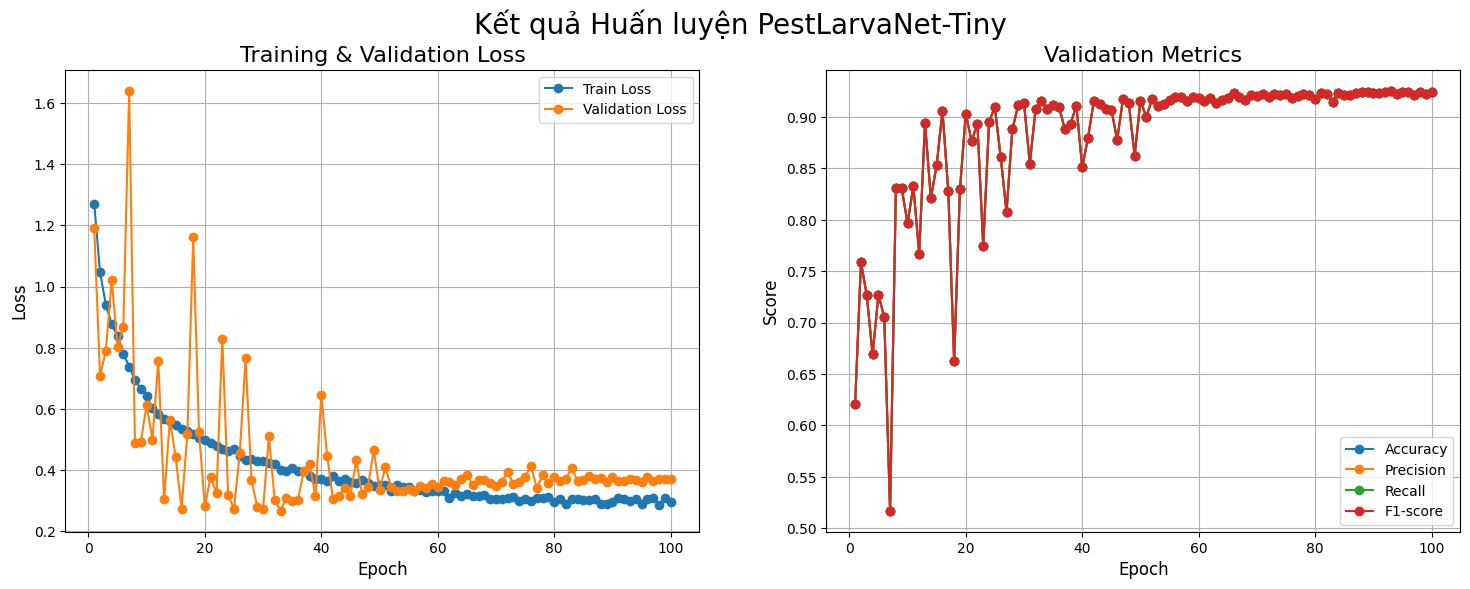

In [17]:
log_df = pd.read_csv(LOG_CSV_PATH)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

ax1.plot(log_df['epoch'], log_df['train_loss'], label='Train Loss', marker='o')
ax1.plot(log_df['epoch'], log_df['val_loss'], label='Validation Loss', marker='o')
ax1.set_title('Training & Validation Loss', fontsize=16)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.legend()
ax1.grid(True)

ax2.plot(log_df['epoch'], log_df['accuracy'], label='Accuracy', marker='o')
ax2.plot(log_df['epoch'], log_df['precision'], label='Precision', marker='o')
ax2.plot(log_df['epoch'], log_df['recall'], label='Recall', marker='o')
ax2.plot(log_df['epoch'], log_df['f1'], label='F1-score', marker='o')
ax2.set_title('Validation Metrics', fontsize=16)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Score', fontsize=12)
ax2.legend()
ax2.grid(True)

plt.suptitle('Kết quả Huấn luyện PestLarvaNet-Tiny', fontsize=20)
plt.show()


Tải trọng số model tốt nhất để vẽ Confusion Matrix.


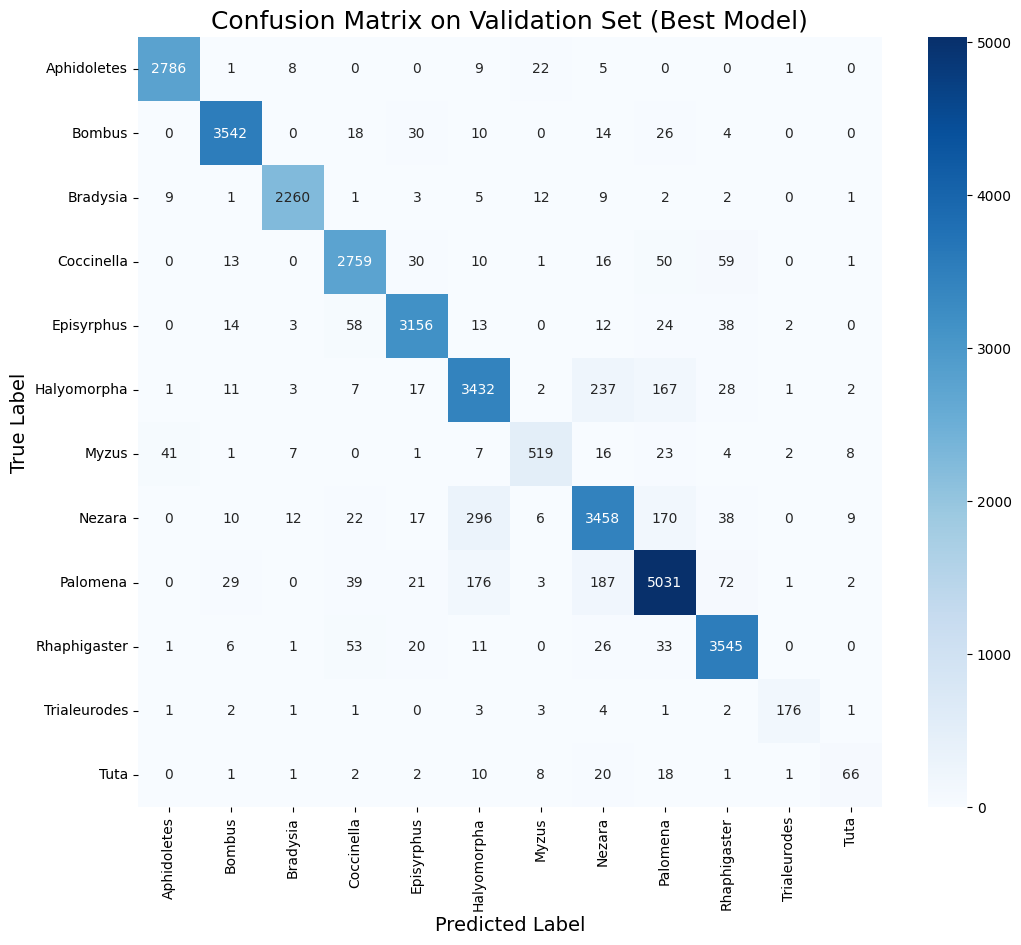

In [18]:
best_model_path = os.path.join(CHECKPOINT_DIR, 'best_model.pth')
if os.path.exists(best_model_path):
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    print("\nTải trọng số model tốt nhất để vẽ Confusion Matrix.")
    
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in val_loader:
        if -1 in labels: continue
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=full_dataset.class_names, 
            yticklabels=full_dataset.class_names)
plt.title('Confusion Matrix on Validation Set (Best Model)', fontsize=18)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.show()